In [1]:
#import all of basic lib
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, Conv2D, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)
from tensorflow.keras import backend

In [ ]:
 #unzip and load dataset, once
"""from zipfile import ZipFile

with ZipFile(
    '/content/drive/MyDrive/Malaria-dataset/dataset-malaria-gr.zip',
    'r'
) as zip:
  zip.extractall('/content/drive/MyDrive/Malaria-dataset')"""

"from zipfile import ZipFile\n\nwith ZipFile(\n   '/content/drive/MyDrive/Malaria-dataset/dataset-malaria-gr.zip',\n   'r'\n) as zip:\n zip.extractall('/content/drive/MyDrive/Malaria-dataset')"

In [2]:
#check all dispo dir
os.listdir('/content/drive/MyDrive/Malaria-dataset')

['Parasitized',
 'Uninfected',
 'dataset-malaria-gr.zip',
 'model_malaria_version_1_00.h5',
 'model_plot.png',
 'my_model1.h5',
 'model_malaria_version_2_00.h5']

In [3]:
#check Parasitized data image in index 0
print(os.listdir('/content/drive/MyDrive/Malaria-dataset/Parasitized')[0])

C68P29N_ThinF_IMG_20150819_133447_cell_130.png


In [4]:
#check Uninfected data image in index 10 and its len
print(os.listdir('/content/drive/MyDrive/Malaria-dataset/Uninfected')[10])

C62P23N_ThinF_IMG_20150818_132918_cell_146.png


In [5]:
#source of grouped data image
parasitezedData = os.listdir('/content/drive/MyDrive/Malaria-dataset/Parasitized')
unParasitezedData = os.listdir('/content/drive/MyDrive/Malaria-dataset/Uninfected')

In [6]:
#function to get image length inside a directory :
def count_image_files(directory):
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']
    image_count = 0

    for filename in os.listdir(directory):
        if any(filename.lower().endswith(ext) for ext in image_extensions):
            image_count += 1

    return image_count



In [7]:
#get length of parasitized image
length_parasitized = count_image_files('/content/drive/MyDrive/Malaria-dataset/Parasitized')
length_parasitized

13779

In [8]:
#get length of uninfected image
length_Uninfected = count_image_files('/content/drive/MyDrive/Malaria-dataset/Uninfected')
length_Uninfected

13779

In [9]:
#total images
total_image = length_parasitized + length_Uninfected
total_image

27558

In [10]:
#Combine all the images in one variable and simultaneously resize all image to  50, 50
# Data preprocessing.
dataArrayImage = []
labels = []

for i in parasitezedData:
    try:

        image = cv2.imread("/content/drive/MyDrive/Malaria-dataset/Parasitized/"+i)
        image_array = Image.fromarray(image , 'RGB')
        resize_img = image_array.resize((50 , 50))
        rotated45 = resize_img.rotate(45)
        rotated75 = resize_img.rotate(75)
        blur = cv2.blur(np.array(resize_img) ,(10,10))
        dataArrayImage.append(np.array(resize_img))
        dataArrayImage.append(np.array(rotated45))
        dataArrayImage.append(np.array(rotated75))
        dataArrayImage.append(np.array(blur))
        labels.append(1)
        labels.append(1)
        labels.append(1)
        labels.append(1)

    except AttributeError:
        print('')

for u in unParasitezedData:
    try:

        image = cv2.imread("/content/drive/MyDrive/Malaria-dataset/Uninfected/"+u)
        image_array = Image.fromarray(image , 'RGB')
        resize_img = image_array.resize((50 , 50))
        rotated45 = resize_img.rotate(45)
        rotated75 = resize_img.rotate(75)
        dataArrayImage.append(np.array(resize_img))
        dataArrayImage.append(np.array(rotated45))
        dataArrayImage.append(np.array(rotated75))
        labels.append(0)
        labels.append(0)
        labels.append(0)

    except AttributeError:
        print('')

In [11]:
#data augmentation
cells = np.array(dataArrayImage)
labels = np.array(labels)

np.save('Cells' , cells)
np.save('Labels' , labels)

In [12]:
print('Cells : {} | labels : {}'.format(cells.shape , labels.shape))

Cells : (96453, 50, 50, 3) | labels : (96453,)


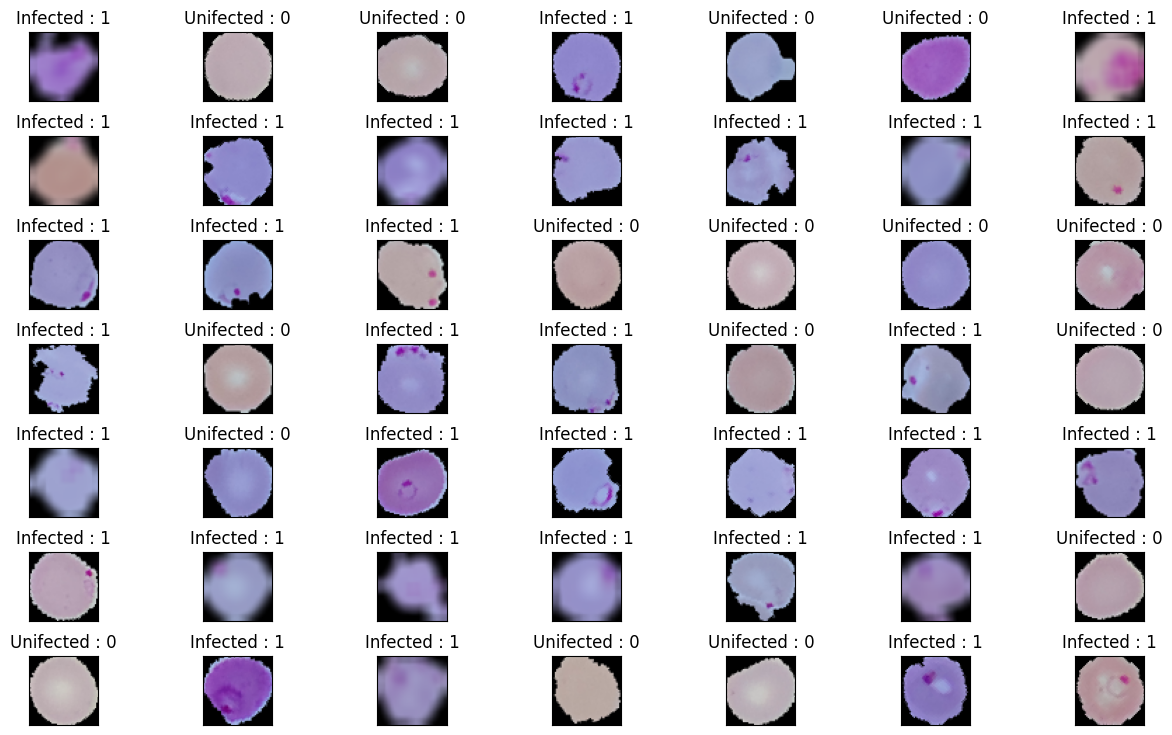

In [13]:
plt.figure(1 , figsize = (15 , 9))
n = 0
for i in range(49):
    n += 1
    r = np.random.randint(0 , cells.shape[0] , 1)
    plt.subplot(7 , 7 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(cells[r[0]])
    plt.title('{} : {}'.format('Infected' if labels[r[0]] == 1 else 'Unifected' ,
                               labels[r[0]]) )
    plt.xticks([]) , plt.yticks([])

plt.show()

In [14]:
# load array as np array for all task
imageData = np.array(dataArrayImage)
labels = np.array(labels)
#test
print("imageData:",len(imageData))
print("labels:",len(labels))


imageData: 96453
labels: 96453


3 Parasitized :



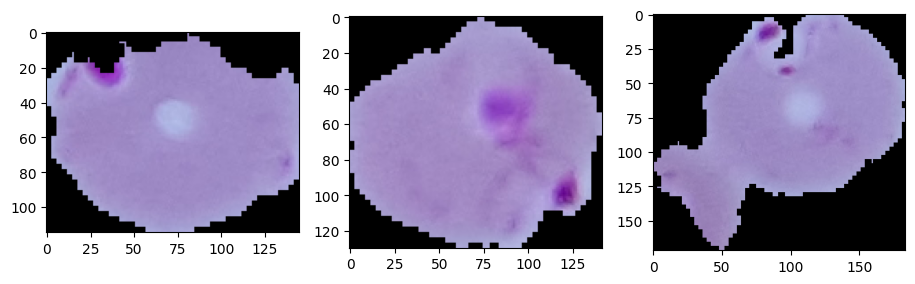

3 Uninfected:



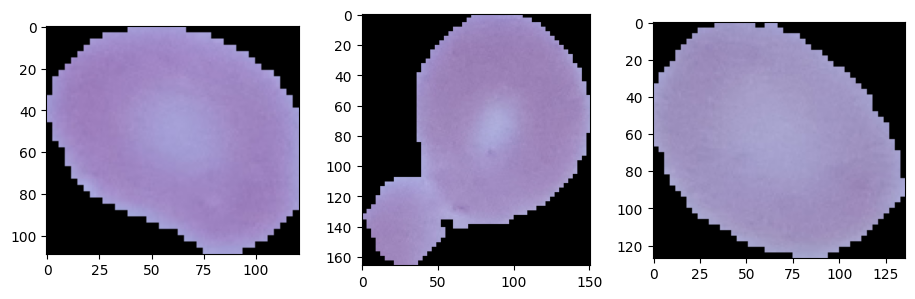

In [15]:
#data viz
print("3 Parasitized :\n")
plt.figure(figsize = (15,15))
for i in range(3):
    plt.subplot(4, 4, i+1)
    img = cv2.imread('/content/drive/MyDrive/Malaria-dataset/Parasitized/'+ parasitezedData[i])
    plt.imshow(img)
plt.show()

print("3 Uninfected:\n")
plt.figure(figsize = (15,15))
for i in range(3):
    plt.subplot(4, 4, i+1)
    img = cv2.imread('/content/drive/MyDrive/Malaria-dataset/Uninfected/'+ unParasitezedData[i])
    plt.imshow(img)
plt.show()

In [16]:
#prepa train and test
from sklearn.model_selection import train_test_split

# Définir la taille de la partition de validation
validation_size = 0.1

# Fractionner les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(imageData, labels, test_size = (validation_size + 0.2), random_state = 0)

# Fractionner l'ensemble de test en ensembles de test et de validation
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = (validation_size / (validation_size + 0.2)), random_state = 0)

# Convertir les labels en format catégorique
y_train = utils.to_categorical(y_train, num_classes = 2)
y_test = utils.to_categorical(y_test, num_classes = 2)
y_val = utils.to_categorical(y_val, num_classes = 2)

# Afficher les tailles des ensembles de données
print("X_train:", len(X_train))
print("X_test:", len(X_test))
print("X_val:", len(X_val))
print("y_train:", len(y_train))
print("y_test:", len(y_test))
print("y_val:", len(y_val))


X_train: 67517
X_test: 19290
X_val: 9646
y_train: 67517
y_test: 19290
y_val: 9646


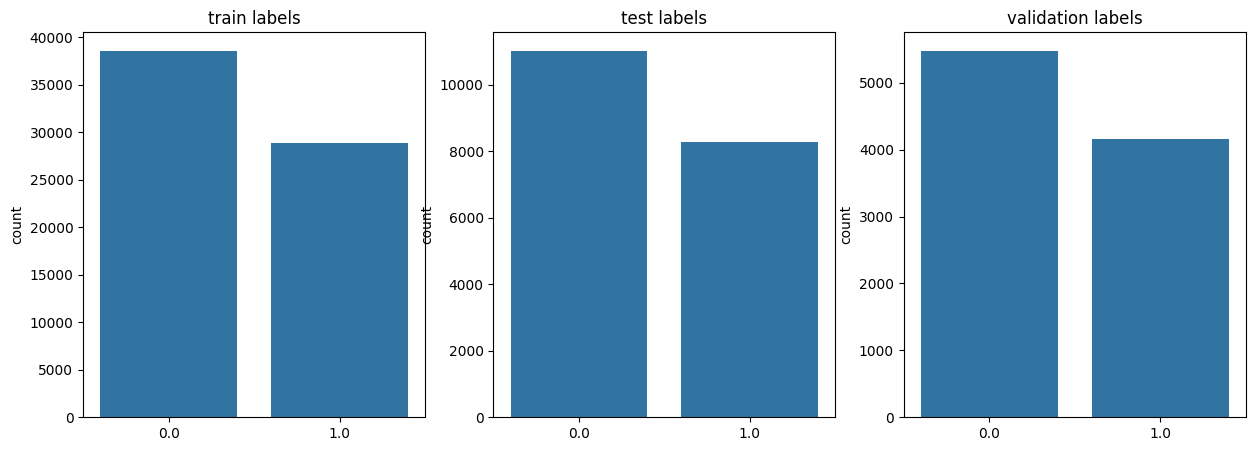

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(1, figsize=(15, 5))
n = 0
for label_data, label in zip([y_train, y_test, y_val], ['train labels', 'test labels', 'validation labels']):
    n += 1
    plt.subplot(1, 3, n)
    sns.countplot(x=label_data[:, 0])
    plt.title(label)
plt.show()

In [18]:
#Use the CNN model

model = Sequential()

inputShape = (50, 50, 3)

if backend.image_data_format() == 'channels_first':
    inputShape = (3, 50, 50)

model.add(Conv2D(32, (3,3), activation='relu', input_shape=inputShape))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 24, 24, 32)        128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 11, 11, 64)        0

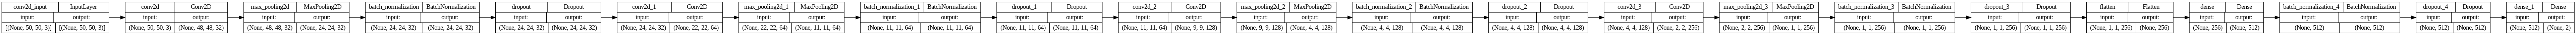

In [19]:
from tensorflow.keras.utils import plot_model

# Visualisation du modèle avec plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, rankdir='LR', expand_nested=True)

In [20]:
#Compilation
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [21]:
# Set up logging for predictions
import tensorflow as tf
tensors_to_log = {'probabilities': 'softmax_tensor'}
logging_hook = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_images=True)

In [22]:
#model fitting
history = model.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
2110/2110 [==============================] - 393s 182ms/step - loss: 0.2690 - accuracy: 0.9001
Epoch 2/30
2110/2110 [==============================] - 383s 181ms/step - loss: 0.1563 - accuracy: 0.9483
Epoch 3/30
2110/2110 [==============================] - 370s 175ms/step - loss: 0.1481 - accuracy: 0.9510
Epoch 4/30
2110/2110 [==============================] - 365s 173ms/step - loss: 0.1398 - accuracy: 0.9528
Epoch 5/30
2110/2110 [==============================] - 358s 170ms/step - loss: 0.1334 - accuracy: 0.9550
Epoch 6/30
2110/2110 [==============================] - 347s 164ms/step - loss: 0.1264 - accuracy: 0.9574
Epoch 7/30
2110/2110 [==============================] - 352s 167ms/step - loss: 0.1218 - accuracy: 0.9591
Epoch 8/30
2110/2110 [==============================] - 357s 169ms/step - loss: 0.1187 - accuracy: 0.9592
Epoch 9/30
2110/2110 [==============================] - 350s 166ms/step - loss: 0.1151 - accuracy: 0.9611
Epoch 10/30
2110/2110 [=======================

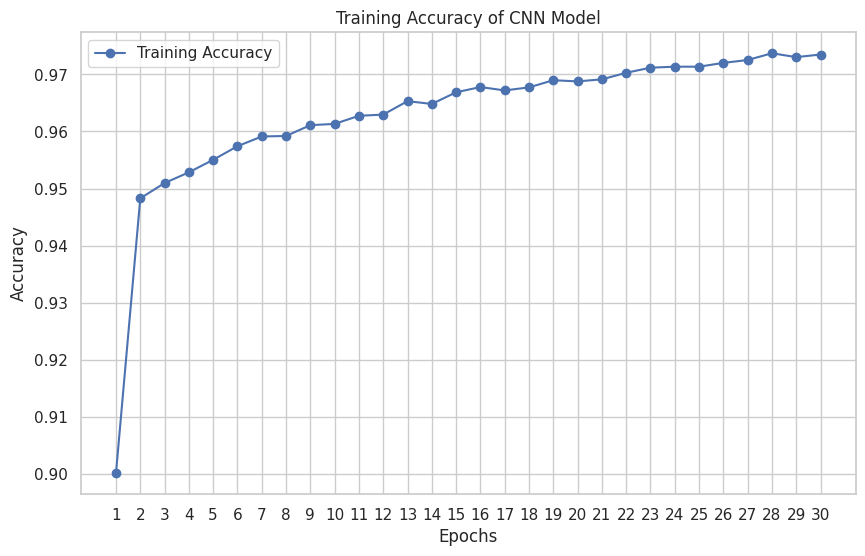

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
# Extraire l'accuracy sur les données d'entraînement ('accuracy')
train_accuracy = history.history['accuracy']

# Définir les epochs
epochs = range(1, len(train_accuracy) + 1)

# Créer un graphique d'accuracy en fonction des epochs
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o', linestyle='-')
plt.title('Training Accuracy of CNN Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend()
plt.show()

In [24]:
model.save('my_model_cnn_custom_8-04-2024.h5')  # Save the model after initial training

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 24, 24, 32)        128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 11, 11, 64)        0

In [27]:
# Evaluation sur des données de validation
validation_loss, validation_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {validation_accuracy:.4f}")

# Evaluation sur des données de test
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

302/302 [==============================] - 14s 46ms/step - loss: 0.0962 - accuracy: 0.9685
Validation Accuracy: 0.9685
603/603 [==============================] - 28s 46ms/step - loss: 0.0918 - accuracy: 0.9665
Test Accuracy: 0.9665


In [28]:
#evaluation de l'ensemble de test en calculant la perte et la précision
predict = model.evaluate(X_test, y_test)
print("Loss: ",predict[0])
print("Accuracy: ",predict[1]*100)

603/603 [==============================] - 28s 46ms/step - loss: 0.0918 - accuracy: 0.9665
Loss:  0.0917634516954422
Accuracy:  96.65111303329468


In [30]:
#Matrice de confusion
from sklearn.metrics import confusion_matrix

In [31]:
#Prédire les classes sur l'ensemble de test
y_pred = model.predict(X_test)

603/603 [==============================] - 32s 53ms/step


In [32]:
# Convertir les prédictions en classes:
y_pred_classes = np.argmax(y_pred, axis=1)

In [33]:
print("y_train type:", type(y_train))
print("y_test type:", type(y_test))
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train type: <class 'numpy.ndarray'>
y_test type: <class 'numpy.ndarray'>
y_train shape: (67517, 2)
y_test shape: (19290, 2)


In [34]:
#Création de la matrice de confusion:
y_test_binary = np.argmax(y_test, axis=1)
confusion_mat = confusion_matrix(y_test_binary, y_pred_classes)
confusion_mat

array([[ 8035,   229],
       [  417, 10609]])

Rapport de Classification :
603/603 [==============================] - 27s 45ms/step
Format de y_test : (19290, 2)


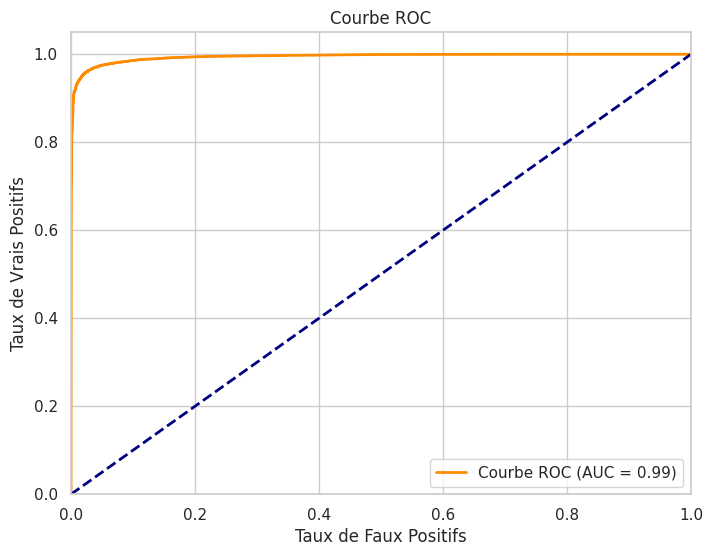

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc


# Afficher le rapport de classification
print('Rapport de Classification :')
num_classes = 2
y_pred_prob = model.predict(X_test)
# Supposez que vous avez déjà des prédictions du modèle sur des données de test (y_pred) et les probabilités prédites (y_pred_prob)

# Vérifiez le format de y_test
print('Format de y_test :', y_test.shape)  # Assurez-vous que y_test est au format attendu

# Si y_test est au format multilabel-indicator, convertissez-le en un format adapté à la classification binaire
if y_test.ndim > 1 and y_test.shape[1] > 1:
    y_test_binary = y_test.argmax(axis=1)  # Convertit en un tableau de classes binaires (0 ou 1)
else:
    y_test_binary = y_test  # Utilise directement y_test si déjà au format binaire

# Tracer la courbe ROC pour la classification binaire
y_true_binary = np.argmax(y_test, axis=1)

# Tracer la courbe ROC pour la classification binaire
fpr, tpr, _ = roc_curve(y_true_binary, y_pred_prob[:, 1])  # Utiliser y_pred_prob[:, 1] pour les probabilités de la classe positive
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

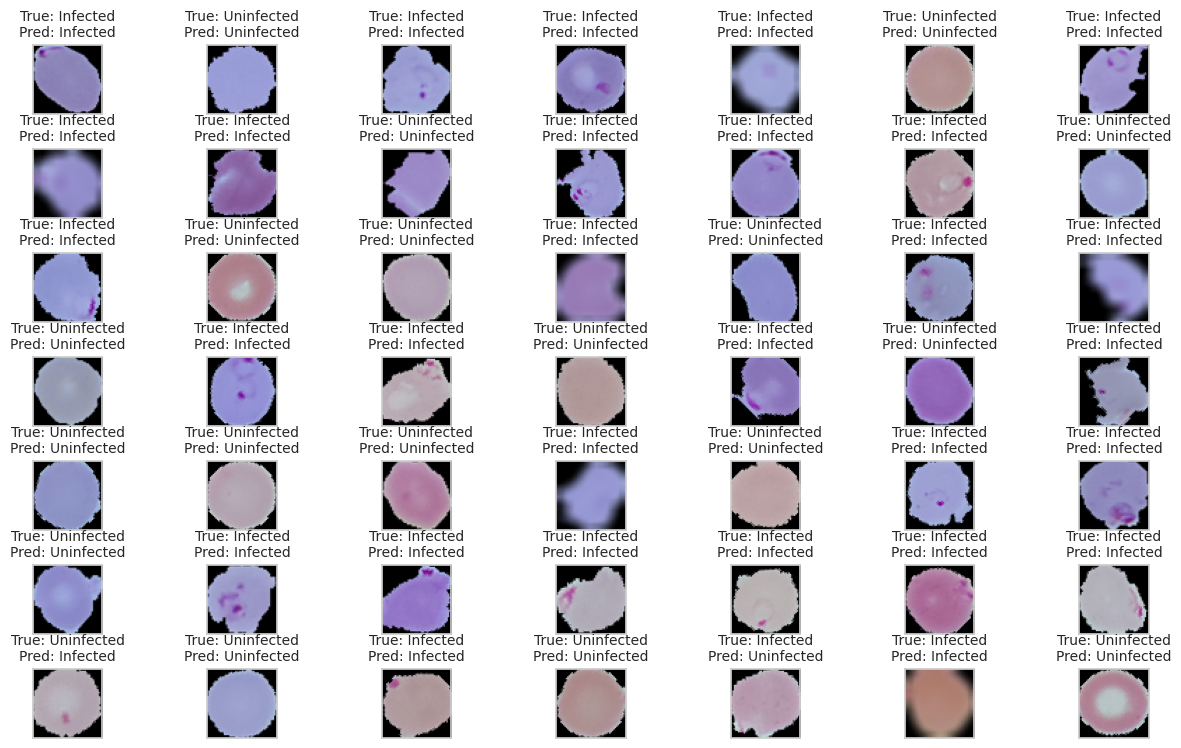

In [40]:
plt.figure(1, figsize=(15, 9))
n = 0

# Assuming one-hot encoded labels
classes = ["Uninfected", "Infected"]  # Define class names for readability

for i in range(49):
    n += 1
    r = np.random.randint(0, X_test.shape[0], 1)

    # Check if subplot position is within grid capacity
    if n <= 49:
        plt.subplot(7, 7, n)
        plt.subplots_adjust(hspace=0.5, wspace=0.5)

        # Get true and predicted labels from y_test and y_pred
        true_label_index = np.argmax(y_test[r[0]])  # Convert one-hot encoded label to index
        predicted_label_index = np.argmax(y_pred[r[0]])
        true_label = classes[true_label_index]
        predicted_label = classes[predicted_label_index]

        plt.imshow(X_test[r[0]])
        plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=10)  # Clear title with labels
        plt.xticks([]), plt.yticks([])

plt.show()

In [41]:
#Saving model
%cd "/content/drive/MyDrive/Malaria-dataset"
model.save('model_malaria_version_3_00.h5')
from tensorflow.keras.models import load_model
model = load_model('model_malaria_version_3_00.h5')
model.summary()

/content/drive/MyDrive/Malaria-dataset


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 24, 24, 32)        128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 11, 11, 64)        0

**EfficientNet :**
EfficientNet est une architecture de CNN introduite en 2019 qui vise à optimiser les performances en termes de précision et d'efficacité computationnelle. Elle utilise une approche d'équilibrage des dimensions de réseau en modifiant simultanément la largeur, la profondeur et la résolution des modèles. Les modèles EfficientNet sont conçus pour être plus performants que d'autres architectures avec une taille de modèle similaire.
On va combiner ce type de CNN avec notre modèle

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt


Correction de chargement de données de test, eval et train

In [ ]:
# Définir la taille de la partition de validation
validation_size = 0.1

# Fractionner les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(imageData, labels, test_size = (validation_size + 0.2), random_state = 0)

# Fractionner l'ensemble de test en ensembles de test et de validation
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = (validation_size / (validation_size + 0.2)), random_state = 0)

# Convertir les labels en format catégorique
y_train = to_categorical(y_train, num_classes = 2)
y_test = to_categorical(y_test, num_classes = 2)
y_val = to_categorical(y_val, num_classes = 2)

# Afficher les tailles des ensembles de données
print("X_train:", len(X_train))
print("X_test:", len(X_test))
print("X_val:", len(X_val))
print("y_train:", len(y_train))
print("y_test:", len(y_test))
print("y_val:", len(y_val))


X_train: 67517
X_test: 19290
X_val: 9646
y_train: 67517
y_test: 19290
y_val: 9646


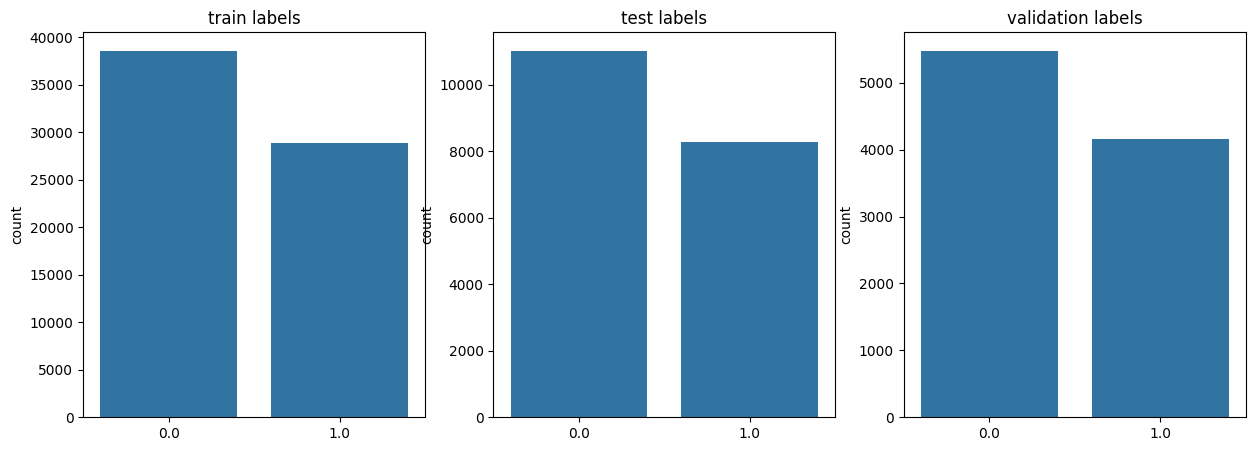

In [ ]:

plt.figure(1, figsize=(15, 5))
n = 0
for label_data, label in zip([y_train, y_test, y_val], ['train labels', 'test labels', 'validation labels']):
    n += 1
    plt.subplot(1, 3, n)
    sns.countplot(x=label_data[:, 0])
    plt.title(label)
plt.show()

In [ ]:
# Convertir les labels en format catégorique
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)

Modèle EfficientNetB0:

In [ ]:
# Chargement du modèle EfficientNetB0 sans les couches supérieures
base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Ajout des nouvelles couches au modèle EfficientNet
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

# Création du modèle final
model_efficientnet = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Geler les poids de toutes les couches de base_model
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Compilation du modèle
model_efficientnet.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Nouvelle section